In [1]:
'''
Here is studied how to improve the performances of QPE firstly by selecting the transpiled 
circuit with the best (i.e. least) depth in order to avoid as much as possible 
the noise due to interaction between qubits

Secondly a standard error measurment correction is implemented via a calibration of the
backend in use

Comparison will be plotted as histograms at the end
'''

'\nHere is studied how to improve the performances of QPE firstly by selecting the transpiled \ncircuit with the best (i.e. least) depth in order to avoid as much as possible \nthe noise due to interaction between qubits\n\nSecondly a standard error measurment correction is implemented via a calibration of the\nbackend in use\n\nComparison will be plotted as histograms at the end\n'

In [34]:
from qiskit import *
from qiskit.providers.ibmq import least_busy
import numpy as np
from qiskit.visualization import plot_histogram
import qiskit.tools.jupyter
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.mitigation.measurement import *
import matplotlib.pyplot as plt

IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

ibmqfactory.load_account:WARNING:2022-02-02 11:17:39,030: Credentials are already in use. The existing account in the session will be replaced.


In [35]:
#functions for qpe circuit

#cp(theta,c,t) are controlled rotation of angle theta controlled by 'c' on target 't'
#this function implement all the rotations the qft requires
def qft_rot(qc,n):
    if n==0:
        return qc
    n -= 1
    qc.h(n)
    for q in range(n):
        qc.cp(np.pi/(2**(n-q)),q,n)
    #applies H and rotation iteratively to every q bit from the most significant to the least sig.
    qft_rot(qc,n)

def swap_register(qc,n):
    for q in range(n//2):
        qc.swap(q,n-1-q)
    return qc

def qft(qc,n):
    qft_rot(qc,n)
    qc.barrier()
    swap_register(qc,n)
    return qc
    
#inverse qft
#append an inverse qft circuit to the first n qbits of an existing one
def inv_qft(qc,n):
    dum_circ = qft(QuantumCircuit(n),n)
    dum_circ = dum_circ.inverse()#invert i.e takes the adjoint
    #now append the inverse qft circuit (qft_circ) to qc
    dum_circ.name="QFT†"
    qc.append(dum_circ,qc.qubits[:n])
    return qc

#implementation of the operator
'''
qpe gives the theta in U|u>=exp(i2pitheta)|u>, 
here the funtion applies |u> -> exp(iangle)|u> via .cp() funcion,
so in order to find theta one has to give the function 2pi*angle as an argument
'''

def apply_U(qc,angle,t,qtot):

    circ_dum = QuantumCircuit(qtot)
    repetitions = 1
    for q in range(t):
        for k in range(repetitions):
            circ_dum.cp(angle,q,qtot-1)#operator
        repetitions *= 2
    circ_dum.name="U"
    qc.append(circ_dum,qc.qubits[:qtot])    
    return qc

def qpe(qc,t,l,theta):
    
    qtot=t+l
    #qc = QuantumCircuit(qtot,t)
    
    for q in range(t):
        qc.h(q)
    
    #implementation of the eigenstate |1>
    qc.x(qtot-1)
    
    qc.barrier()
    
    angle = 2*np.pi*theta #qpe works with 2pi*theta
    qc = apply_U(qc,angle,t,qtot)
    qc.barrier()
    qc = inv_qft(qc,t)
    qc.barrier()
    
    for q in range(t):
        qc.measure(q,q)
    
    return qc

In [41]:
small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                    and not x.configuration().simulator
                                    and x.status().operational==True)

backend = least_busy(small_devices)

print(backend.name())

#backend

ibmq_bogota


In [37]:
'''
here we transpile a qpe circuit a few times in order to notice that the transpile does 
some stochastic SWAPS in order to optimize the circuit for the topology of the real device.
All the circuits are saved in a list, the values of their depth are also stored in a list
'''
qc_trans_all = []
depth_all = []
t=4
l=1
qtot=t+l
theta=1/3

for i in range(300):
    qc = QuantumCircuit(qtot,t)
    qc = qpe(qc,t,l,theta)
    qc_trans = transpile(qc, backend, optimization_level=3)
    qc_trans_all.append(qc_trans)
    depth_all.append(qc_trans.depth())
    
'''
we select the 2 circuit with the best(least) and worst(highest) depth that the SWAP process has produced before
'''
min_depth = min(depth_all)
max_depth = max(depth_all)
min_depth_index = depth_all.index(min_depth)
max_depth_index = depth_all.index(max_depth)

print(min_depth)
print(max_depth)

82
108


In [38]:
shots = 8192
job_min = backend.run(qc_trans_all[min_depth_index], shots=shots)
job_max = backend.run(qc_trans_all[max_depth_index], shots=shots)
print(job_min.job_id())
print(job_max.job_id())
job_monitor(job_min)
job_monitor(job_max)

61fa5b4b11eec7fd3c80928c
61fa5b4e72edae1b78e949af
Job Status: job has successfully run
Job Status: job has successfully run


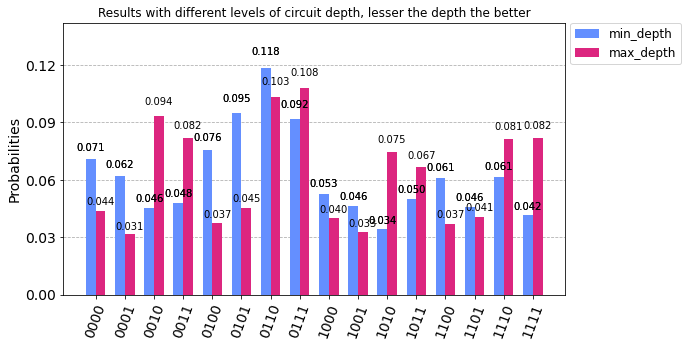

In [46]:
old_min_results = job_min.result()
old_min_counts = old_min_results.get_counts()
old_max_results = job_max.result()
old_max_counts = old_max_results.get_counts()

plot_histogram([old_min_counts,old_max_counts],figsize=(9,5),legend=['min_depth','max_depth'],
               title='Results with different levels of circuit depth, lesser the depth the better')#.savefig(
   # 'C:/Users/nico_/OneDrive/Documenti/Uni/Magistrale/Quantum computing/QPE_bestdepth_vs_worstdepth_small_bogota.png')


In [ ]:
'''
Now we check if correcting measurment errors can improve significantly the 
performance of the QPE, we will see that it is not a big an improvement as the 
selection of the lesser depth transpiled circuit
'''

In [47]:
'''
here we run the calibration circuits
'''
t=4
l=1
qtot=l+t

qr = QuantumRegister(t)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
meas_calibs_trans = transpile(meas_calibs, backend, optimization_level=0)

job = backend.run(meas_calibs_trans, shots = shots)
print(job.job_id())
job_monitor(job)
cal_results = job.result()

61fa65e4e165f5ade978c94a
Job Status: job has successfully run


In [48]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
meas_filter = meas_fitter.filter

mitigated_min_res = meas_filter.apply(old_min_results)
mitigated_min_counts = mitigated_min_res.get_counts()
mitigated_max_res = meas_filter.apply(old_max_results)
mitigated_max_counts = mitigated_max_res.get_counts()

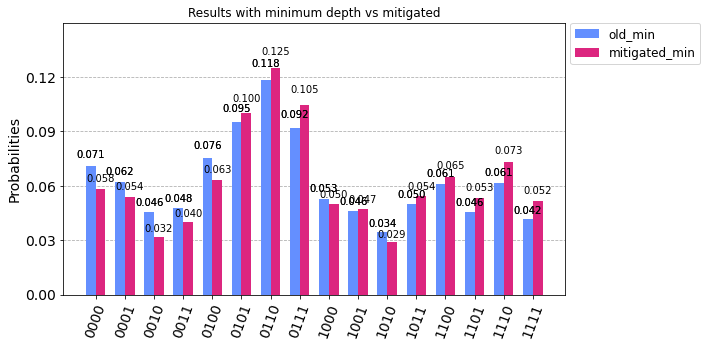

In [54]:
plot_histogram([old_min_counts,mitigated_min_counts], figsize=(9,5),legend=['old_min','mitigated_min'],
               title='Results with minimum depth vs mitigated')#.savefig(
#'C:/Users/nico_/OneDrive/Documenti/Uni/Magistrale/Quantum computing/QPE_mindepthOld_vs_mitigatedMinDepth_small_bogota.png')

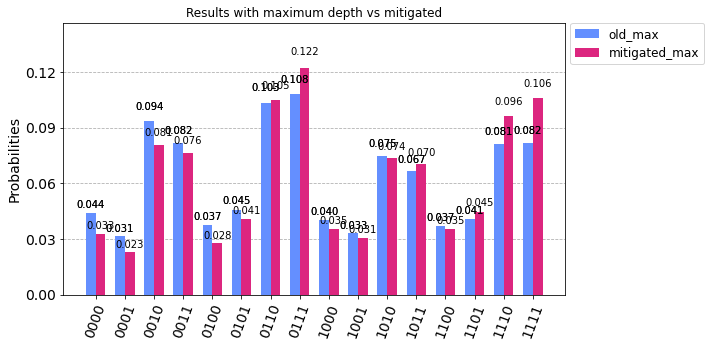

In [55]:
plot_histogram([old_max_counts,mitigated_max_counts], figsize=(9,5),legend=['old_max','mitigated_max'],
               title='Results with maximum depth vs mitigated')#.savefig(
#'C:/Users/nico_/OneDrive/Documenti/Uni/Magistrale/Quantum computing/QPE_mandepthOld_vs_mitigatedMaxDepth_small_bogota.png')